In [1]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
import numpy as np
from rdkit.Chem import Draw
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import ShuffleSplit
from sklearn.svm import SVC
import sklearn.metrics as metrics
import scikitplot as skplt
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.datasets import load_wine
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.metrics import precision_recall_curve
import seaborn as sns; sns.set()
from sklearn.metrics import mean_squared_error

RDKit WARNING: [20:17:00] Enabling RDKit 2019.09.3 jupyter extensions


In [2]:
data = pd.read_csv('/home/valeriia/bakalarka/bakalarka/LXRb_ch25_curated_DW_2.csv')
# copy raw data
data_new = data.copy()
data_new["Molecule"] = [Chem.MolFromSmiles(mol) for mol in data["smiles"]]

#colmun['Molecule'] invert to binary systems
data_new['bin'] = [np.array(AllChem.GetMorganFingerprintAsBitVect(i,2, nBits=1024)) for i in data_new['Molecule']]


In [16]:
data[:5]

,smiles,chembl_id,potency,pec50,category
0,Cc1cc2c(cc1C(=C)c3ccc(cc3)C(=O)O)C(C)(C)CCC2(C)C,CHEMBL1023,434.000,6.362510,active
1,CCc1nc2c(cccc2nc1c3ccc(cc3)c4cccc(c4)S(=O)(=O)...,CHEMBL1089232,2805.000,5.569777,inactive
2,CS(=O)(=O)c1cccc(c1)c2ccc(CN(Cc3ccc(F)cc3Cl)S(...,CHEMBL1091034,3.162,8.500038,active
3,Cc1ccccc1S(=O)(=O)N(Cc2ccc(cc2)c3cccc(c3)S(=O)...,CHEMBL1091976,3.162,8.500038,active
4,Cn1cnc(c1)S(=O)(=O)N(Cc2ccc(cc2)c3cccc(c3)S(=O...,CHEMBL1092952,79.430,7.100015,active


In [4]:
data_new.pec50.min()

3.9023956711255896

In [5]:
data_new.pec50.max()

9.0

In [3]:
##### classifikation model change thre and than i compare date for diferent thre
#this model predict active/inactive compounds
#case1
random_state = 20
thre = 7

#add new columns, number of columns
data_new['number'] = data_new['chembl_id'].rank(method='min')
lab_enc = preprocessing.LabelEncoder()
data_new['number']= lab_enc.fit_transform(data_new['number'])
data_new['category_new'] = np.where(data_new['pec50']>=thre, 1, 0)

#divided date for two sets: train and test
train, test = train_test_split(data_new, test_size = 0.25, random_state = random_state)
train, test = train.copy(), test.copy()
x_train = np.asarray([x for x in train['bin']])
x_test = np.asarray([x for x in test['bin']]) 
y_train = np.asarray([y for y in train['category_new']])
y_test = np.asarray([y for y in test['category_new']])

#RandomForesrClassifier
crf = RandomForestClassifier(n_estimators=101, max_depth=4, random_state=random_state)
crf.fit(x_train,y_train)

# prediction on test set
crf_predict = crf.predict(x_test)

#CLassification:
   #accuracy, spe, sen, MCC,
    #confusion matrices (true positive, true negative, false positive, false negative (TP, TN, FP, FN))
    
#confusion_matrix
print("Confusion_matrix for test set:")
conf_matrix = confusion_matrix(crf.predict(x_test), y_test)
print(conf_matrix)
TN, FP, FN, TP = conf_matrix.ravel()
d = {' ': ['actual+', 'actual-'], 'predicted+':[TP, FN], 'predicted-':[FP, TN]}
df = pd.DataFrame(data=d)
print("\n")
print(df)
print("\n")

#Accuracy
print("Accuracy:",metrics.accuracy_score(y_test, crf.predict(x_test)))
print("\n")
print("=== Classification Report ===")
print(classification_report(y_test, crf_predict))

# Performance metrics
errors = abs(crf_predict - y_test)
#print('Average absolute error:', round(np.mean(errors), 2), 'degrees.')
# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
#MCC
MCC = ((TP*TN)-(FP*FN))/((TP+FP)*(FN+TN)*(FP+TN)*(TP+FN))**(1/2)
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)
# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)

#put data for pandas data_out
try:
    da = {'threshold': [thre],'Accuracy':[ACC], 'Sensitiv.':[TPR], 'Specif.':[TNR], 'MCC':[MCC],
      'Positive pred':[PPV], 'Negative pred':[NPV], 'False positive':[FPR], 'False negative':[FNR]}
    dff = pd.DataFrame(data=da)

    data_out = data_out.append(dff, ignore_index = True)
    data_out.drop_duplicates(keep='first', inplace=True)
except:
    da = {'threshold': [],'Accuracy':[], 'Sensitiv.':[], 'Specif.':[], 'MCC':[],
      'Positive pred':[], 'Negative pred':[], 'False positive':[], 'False negative':[]}
    data_out = pd.DataFrame(data=da)



y_score1 = crf.predict_proba(x_test)[:,1]
false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(y_test, y_score1)
print('roc_auc_score for RandomForestClassification: ', round(roc_auc_score(y_test, y_score1),4))



Confusion_matrix for test set:
[[231  32]
 [  0   7]]


            predicted+  predicted-
0  actual+           7          32
1  actual-           0         231


Accuracy: 0.8814814814814815


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.88      1.00      0.94       231
           1       1.00      0.18      0.30        39

    accuracy                           0.88       270
   macro avg       0.94      0.59      0.62       270
weighted avg       0.90      0.88      0.84       270

roc_auc_score for RandomForestClassification:  0.9154


In [92]:
data_out.head()

,threshold,Accuracy,Sensitiv.,Specif.,MCC,Positive pred,Negative pred,False positive,False negative
0,7.0,0.881481,1.000000,0.878327,0.397050,0.179487,1.000000,0.121673,0.000000
1,5.0,0.918519,0.923611,0.912698,0.836310,0.923611,0.912698,0.087302,0.076389
2,5.5,0.870370,0.852713,0.886525,0.740154,0.873016,0.868056,0.113475,0.147287
3,6.0,0.800000,0.880000,0.781818,0.542414,0.478261,0.966292,0.218182,0.120000
4,6.5,0.803704,0.923077,0.797665,0.362823,0.187500,0.995146,0.202335,0.076923


In [97]:
data_out.to_csv('data_out_diferent_threshold_clasification_model.csv', encoding='utf-8')

In [22]:
#CROSS VALIDATION
n_splits = 5
thre = 7
random_state = 20

data_new['number'] = data_new['chembl_id'].rank(method='min')
lab_enc = preprocessing.LabelEncoder()
data_new['number']= lab_enc.fit_transform(data_new['number'])
data_new['category_new'] = np.where(data_new['pec50']>=thre, 1, 0)

cros_x = np.asarray([x for x in data_new['bin']])
cros_y = np.asarray([y for y in data_new['category_new']])
scores = cross_val_score(crf, cros_x, cros_y, cv=n_splits)
print("Cross_validation_score", scores)
#Cross Validation
print("Cross validation:")
kf = KFold(n_splits = n_splits)
a = -1   
        
for trains, tests in kf.split(cros_x, cros_y):
    a = a+1
    print('Number of split:', a)
    rfc = RandomForestClassifier(n_estimators=101, max_depth=4, random_state=random_state)
    rfc.fit(cros_x[trains],cros_y[trains])
    print("Accuracy:",metrics.accuracy_score(cros_y[tests], rfc.predict(cros_x[tests])))
    rfc_predict = rfc.predict(cros_x[tests])
    
    conf_matrix = confusion_matrix(rfc.predict(cros_x[tests]),
                                   cros_y[tests])
    
    print(conf_matrix)
    
    accur = metrics.accuracy_score(cros_y[tests], rfc.predict(cros_x[tests]))
    if(accur == 1):
        ACC = 1
        TPR = 1
        TNR = 1
        MCC = 1
        PPV = 1
        NPV = 1
        FPR = 1
        FNR = 1
        FDR = 1
    else:
        TN, FP, FN, TP = conf_matrix.ravel()
        # Sensitivity, hit rate, recall, or true positive rate
        TPR = TP/(TP+FN)
        # Specificity or true negative rate
        TNR = TN/(TN+FP)
        #MCC
        MCC = ((TP*TN)-(FP*FN))/((TP+FP)*(FN+TN)*(FP+TN)*(TP+FN))**(1/2)
        # Precision or positive predictive value
        PPV = TP/(TP+FP)
        # Negative predictive value
        NPV = TN/(TN+FN)
        # Fall out or false positive rate
        FPR = FP/(FP+TN)
        # False negative rate
        FNR = FN/(TP+FN)
        # False discovery rate
        FDR = FP/(TP+FP)
        # Overall accuracy
        ACC = (TP+TN)/(TP+FP+FN+TN)
    
    
    #put data for pandas data_out   
    try:
        dat = {'threshold': [thre],'N_Split':[n_splits],'Split':[a],'Accuracy':[ACC], 'Sensitiv.':[TPR], 'Specif.':[TNR], 'MCC':[MCC],
            'Positive pred':[PPV], 'Negative pred':[NPV], 'False positive':[FPR], 'False negative':[FNR]}
        daf = pd.DataFrame(data=dat)
        
        data_vystup = data_vystup.append(daf, ignore_index = True)
        data_vystup.drop_duplicates(keep='first', inplace=True) 
    except:
       
        dat = {'threshold': [],'N_Split':[], 'Split':[],'Accuracy':[], 'Sensitiv.':[], 'Specif.':[], 'MCC':[],
          'Positive pred':[], 'Negative pred':[], 'False positive':[], 'False negative':[]}
        data_vystup = pd.DataFrame(data=dat)
        


Cross_validation_score [0.88425926 0.88425926 0.89814815 0.87962963 0.875     ]
Cross validation:
Number of split: 0
Accuracy: 0.9537037037037037
[[206  10]
 [  0   0]]
Number of split: 1


/home/valeriia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in long_scalars
/home/valeriia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide
/home/valeriia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in long_scalars


Accuracy: 0.9814814814814815
[[212   4]
 [  0   0]]
Number of split: 2


/home/valeriia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in long_scalars
/home/valeriia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide
/home/valeriia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in long_scalars


Accuracy: 0.8842592592592593
[[191  25]
 [  0   0]]
Number of split: 3


/home/valeriia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in long_scalars
/home/valeriia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide
/home/valeriia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in long_scalars


Accuracy: 0.8379629629629629
[[172  33]
 [  2   9]]
Number of split: 4
Accuracy: 0.8194444444444444
[[172  39]
 [  0   5]]


In [23]:
data_vystup.to_csv('vystup_Nsplits5,10_clasification_model.csv', encoding='utf-8')

In [24]:
data_vystup

,threshold,N_Split,Split,Accuracy,Sensitiv.,Specif.,MCC,Positive pred,Negative pred,False positive,False negative
0,6.0,5.0,1.0,0.953704,NaN,0.953704,NaN,0.000000,1.000000,0.046296,NaN
1,6.0,5.0,2.0,0.601852,1.000000,0.586538,0.223424,0.085106,1.000000,0.413462,0.000000
2,6.0,5.0,3.0,0.564815,0.750000,0.553922,0.139617,0.090000,0.974138,0.446078,0.250000
3,6.0,5.0,4.0,0.546296,0.625000,0.523810,0.123753,0.272727,0.830189,0.476190,0.375000
4,5.0,5.0,0.0,0.967593,0.812500,0.994565,0.866921,0.962963,0.968254,0.005435,0.187500
5,5.0,5.0,1.0,0.921296,0.333333,0.946860,0.227418,0.214286,0.970297,0.053140,0.666667
6,5.0,5.0,2.0,0.777778,0.892857,0.653846,0.565670,0.735294,0.850000,0.346154,0.107143
7,5.0,5.0,3.0,0.861111,0.980769,0.550000,0.637905,0.850000,0.916667,0.450000,0.019231
8,5.0,5.0,4.0,0.736111,0.897260,0.400000,0.348422,0.757225,0.651163,0.600000,0.102740
9,5.5,5.0,0.0,0.967593,0.807692,0.989474,0.840949,0.913043,0.974093,0.010526,0.192308


Table when you see old pec50 and new pec50


,pec50,pec50_new
0,6.362510,5.714543
1,5.569777,6.517781
2,8.500038,6.775484
3,8.500038,7.604964
4,7.100015,7.249329
...,...,...
1075,6.769551,6.855233
1076,7.094076,5.840604
1077,5.761954,4.291746
1078,4.170761,4.273384


Regressor score: 0.21633052336270453


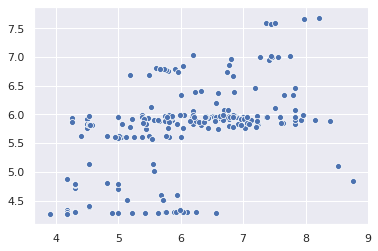

In [25]:
#Regresion model
#case2.1

random_state = 20
train_reg, test_reg = train_test_split(data_new, test_size = 0.25, random_state = random_state)
train_reg, test_reg = train.copy(), test.copy()

data_new_reg = [i for i in data_new['bin']]


x_train_reg = [f for f in train_reg['bin']]
x_test_reg = [f for f in test_reg['bin']]
y_train_reg = [a for a in train_reg['pec50']]
y_test_reg = [a for a in test_reg['pec50']]

rfr = RandomForestRegressor(n_estimators=101,max_depth=4, random_state=random_state)
rfr.fit(x_train_reg, y_train_reg)

y_pred = rfr.predict(x_test_reg)
sns.scatterplot(x=y_test_reg, y=y_pred)

y_pred = rfr.predict(data_new_reg)
data_new['pec50_new'] = y_pred

df = pd.DataFrame({'pec50':[], 'pec50_new':[]})
df['pec50'] = data_new['pec50']
df['pec50_new'] = data_new['pec50_new']
print("Table when you see old pec50 and new pec50")
display(df)


print("Regressor score:", rfr.score(x_test_reg, y_test_reg))

In [6]:
#create classification model after reggresion model
#case2.2s
random_state = 20
thre = 7

#add new column
data_new['category_new_reg'] = np.where(data_new['pec50_new']>=thre, 1, 0)
 

#divided date for two sets: train and test
train, test = train_test_split(data_new, test_size = 0.25, random_state = random_state)
train, test = train.copy(), test.copy()
x_train = np.asarray([x for x in train['bin']])
x_test = np.asarray([x for x in test['bin']]) 
y_train = np.asarray([y for y in train['category_new_reg']])
y_test = np.asarray([y for y in test['category_new_reg']])

#RandomForesrClassifier
crf = RandomForestClassifier(n_estimators=101, max_depth=4, random_state=random_state)
crf.fit(x_train,y_train)

# prediction on test set
crf_predict = crf.predict(x_test)

#CLassification:
   #accuracy, spe, sen, MCC,
    #confusion matrices (true positive, true negative, false positive, false negative (TP, TN, FP, FN))
    
#confusion_matrix
print("Confusion_matrix for test set:")
conf_matrix = confusion_matrix(crf.predict(x_test), y_test)
print(conf_matrix)
TN, FP, FN, TP = conf_matrix.ravel()
d = {' ': ['actual+', 'actual-'], 'predicted+':[TP, FN], 'predicted-':[FP, TN]}
df = pd.DataFrame(data=d)
print("\n")
print(df)
print("\n")

#Accuracy
print("Accuracy:",metrics.accuracy_score(y_test, crf.predict(x_test)))
print("\n")
print("=== Classification Report ===")
print(classification_report(y_test, crf_predict))

# Performance metrics
errors = abs(crf_predict - y_test)
# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
#MCC
MCC = ((TP*TN)-(FP*FN))/((TP+FP)*(FN+TN)*(FP+TN)*(TP+FN))**(1/2)
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)
# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)

#put data for pandas data_out
try:
    dda = {'threshold': [thre],'Accuracy':[ACC], 'Sensitiv.':[TPR], 'Specif.':[TNR], 'MCC':[MCC],
      'Positive pred':[PPV], 'Negative pred':[NPV], 'False positive':[FPR], 'False negative':[FNR]}
    ddff = pd.DataFrame(data=dda)

    data_out_reg = data_out_reg.append(ddff, ignore_index = True)
    data_out_reg.drop_duplicates(keep='first', inplace=True)
except:
    dda = {'threshold': [],'Accuracy':[], 'Sensitiv.':[], 'Specif.':[], 'MCC':[],
      'Positive pred':[], 'Negative pred':[], 'False positive':[], 'False negative':[]}
    data_out_reg = pd.DataFrame(data=dda)



y_score1 = crf.predict_proba(x_test)[:,1]
false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(y_test, y_score1)
print('roc_auc_score for RandomForestClassification: ', round(roc_auc_score(y_test, y_score1),4))


Confusion_matrix for test set:
[[259   3]
 [  1   7]]


            predicted+  predicted-
0  actual+           7           3
1  actual-           1         259


Accuracy: 0.9851851851851852


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       260
           1       0.88      0.70      0.78        10

    accuracy                           0.99       270
   macro avg       0.93      0.85      0.89       270
weighted avg       0.98      0.99      0.98       270

roc_auc_score for RandomForestClassification:  0.9985


In [76]:
data_out_reg.head()

,threshold,Accuracy,Sensitiv.,Specif.,MCC,Positive pred,Negative pred,False positive,False negative
0,5.5,0.966667,0.992754,0.939394,0.934485,0.944828,0.992000,0.060606,0.007246
1,5.0,0.970370,0.986111,0.952381,0.940776,0.959459,0.983607,0.047619,0.013889
2,6.0,0.870370,0.939759,0.839572,0.734028,0.722222,0.969136,0.160428,0.060241
3,6.5,0.955556,1.000000,0.953125,0.716395,0.538462,1.000000,0.046875,0.000000
4,7.0,0.985185,0.875000,0.988550,0.775347,0.700000,0.996154,0.011450,0.125000


In [100]:
data_out_reg.to_csv('data_out_reg_diferentthreshold_clasification_modelafter_reg.csv',  encoding='utf-8')

In [70]:
data_clas = pd.read_csv('/home/valeriia/bakalarka/bakalarka/data_out_diferent_threshold_clasification_model.csv')
print("Data for classifikation model(step 1)")
data_clas.head()

Data for classifikation model(step 1)


,Unnamed: 0,threshold,Accuracy,Sensitiv.,Specif.,MCC,Positive pred,Negative pred,False positive,False negative
0,0,7.0,0.881481,1.000000,0.878327,0.397050,0.179487,1.000000,0.121673,0.000000
1,1,5.0,0.918519,0.923611,0.912698,0.836310,0.923611,0.912698,0.087302,0.076389
2,2,5.5,0.870370,0.852713,0.886525,0.740154,0.873016,0.868056,0.113475,0.147287
3,3,6.0,0.800000,0.880000,0.781818,0.542414,0.478261,0.966292,0.218182,0.120000
4,4,6.5,0.803704,0.923077,0.797665,0.362823,0.187500,0.995146,0.202335,0.076923


In [60]:
data_clas_cros = pd.read_csv('/home/valeriia/bakalarka/bakalarka/vystup_Nsplits5,10_clasification_model.csv')
print("Data after croos validation for classification model (step1)")
data_clas_cros

Data after croos validation for classification model (step1)


,Unnamed: 0,threshold,N_Split,Split,Accuracy,Sensitiv.,Specif.,MCC,Positive pred,Negative pred,False positive,False negative
0,0,5.0,5.0,0.0,0.967593,0.812500,0.994565,0.866921,0.962963,0.968254,0.005435,0.187500
1,1,5.0,5.0,1.0,0.921296,0.333333,0.946860,0.227418,0.214286,0.970297,0.053140,0.666667
2,2,5.0,5.0,2.0,0.777778,0.892857,0.653846,0.565670,0.735294,0.850000,0.346154,0.107143
3,3,5.0,5.0,3.0,0.861111,0.980769,0.550000,0.637905,0.850000,0.916667,0.450000,0.019231
4,4,5.0,5.0,4.0,0.736111,0.897260,0.400000,0.348422,0.757225,0.651163,0.600000,0.102740
...,...,...,...,...,...,...,...,...,...,...,...,...
70,70,7.0,10.0,5.0,0.944444,NaN,0.944444,NaN,0.000000,1.000000,0.055556,NaN
71,71,7.0,10.0,6.0,0.898148,NaN,0.898148,NaN,0.000000,1.000000,0.101852,NaN
72,72,7.0,10.0,7.0,0.787037,0.900000,0.775510,0.432831,0.290323,0.987013,0.224490,0.100000
73,73,7.0,10.0,8.0,0.833333,0.777778,0.838384,0.415968,0.304348,0.976471,0.161616,0.222222


In [62]:
data_clas_reg = pd.read_csv('/home/valeriia/bakalarka/bakalarka/data_out_reg_diferentthreshold_clasification_modelafter_reg.csv')
print("Data classifikation(which i built after regresion model)(step 2)")
data_clas_reg

Data classifikation(which i built after regresion model)(step 2)


,Unnamed: 0,threshold,Accuracy,Sensitiv.,Specif.,MCC,Positive pred,Negative pred,False positive,False negative
0,0,5.5,0.966667,0.992754,0.939394,0.934485,0.944828,0.992000,0.060606,0.007246
1,1,5.0,0.970370,0.986111,0.952381,0.940776,0.959459,0.983607,0.047619,0.013889
2,2,6.0,0.870370,0.939759,0.839572,0.734028,0.722222,0.969136,0.160428,0.060241
3,3,6.5,0.955556,1.000000,0.953125,0.716395,0.538462,1.000000,0.046875,0.000000
4,4,7.0,0.985185,0.875000,0.988550,0.775347,0.700000,0.996154,0.011450,0.125000


In [7]:
#NEW KOD:
#end table

data = pd.read_csv('/home/valeriia/bakalarka/bakalarka/LXRb_ch25_curated_DW_2.csv')
# copy raw data
data_new_2 = data.copy()
data_new_2["Molecule"] = [Chem.MolFromSmiles(mol) for mol in data["smiles"]]

#colmun['Molecule'] invert to binary systems
data_new_2['bin'] = [np.array(AllChem.GetMorganFingerprintAsBitVect(i,2, nBits=1024)) for i in data_new_2['Molecule']]


/home/valeriia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in long_scalars
/home/valeriia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in true_divide


Regr 0.6540539722230213


/home/valeriia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in long_scalars
/home/valeriia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in true_divide
/home/valeriia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in long_scalars
/home/valeriia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in true_divide


Regr 0.40994541417868363


/home/valeriia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in long_scalars
/home/valeriia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in true_divide


Regr 0.7541837378282931
Regr 0.7794605727865181
Regr 0.9650674254426206


,Case,threshold,Split,Accuracy,Sensitiv.,Specif.,MCC
0,1.0,5.0,0.0,0.967593,0.812500,0.994565,0.866921
1,1.0,5.0,1.0,0.921296,0.333333,0.946860,0.227418
2,1.0,5.0,2.0,0.777778,0.892857,0.653846,0.565670
3,1.0,5.0,3.0,0.861111,0.980769,0.550000,0.637905
4,1.0,5.0,4.0,0.736111,0.897260,0.400000,0.348422
5,1.0,5.5,0.0,0.967593,0.807692,0.989474,0.840949
6,1.0,5.5,1.0,0.921296,0.000000,0.952153,-0.040322
7,1.0,5.5,2.0,0.745370,0.863636,0.664062,0.521282
8,1.0,5.5,3.0,0.546296,0.920635,0.392157,0.309975
9,1.0,5.5,4.0,0.615741,0.801802,0.419048,0.239626


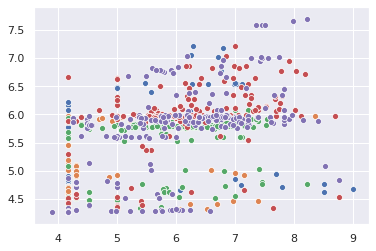

In [13]:
#END table of all model
n_splits = 5
thre = 7
random_state = 20
data_new_2['number'] = data_new_2['chembl_id'].rank(method='min')
lab_enc = preprocessing.LabelEncoder()
data_new_2['number']= lab_enc.fit_transform(data_new_2['number'])
#category_new is column where have convert category(inactive/active) to (0,1)
data_new_2['category_new'] = np.where(data_new_2['pec50']>=thre, 1, 0)

kf = KFold(n_splits = n_splits)
a = -1   
       
for trains, tests in kf.split(data_new_2):
    a = a+1
    #print('Number of split:', a)
    train = data_new_2.iloc[trains]
    test = data_new_2.iloc[tests]
    #clasification, i used bin and category new columns   
    case = 1
    x_train = np.asarray([x for x in train['bin']])
    x_test = np.asarray([x for x in test['bin']]) 
    y_train = np.asarray([y for y in train['category_new']])
    y_test = np.asarray([y for y in test['category_new']])
    
    rfc = RandomForestClassifier(n_estimators=101, max_depth=4, random_state=random_state)
    rfc.fit(x_train,y_train)
    rfc_predict = rfc.predict(x_test)
    conf_matrix = confusion_matrix(rfc.predict(x_test), y_test)
    TN, FP, FN, TP = conf_matrix.ravel()
    
    accur = metrics.accuracy_score(y_test, rfc.predict(x_test))
    #print(accur)
    
    # Sensitivity
    TPR = TP/(TP+FN)
    # Specificity 
    TNR = TN/(TN+FP)
    #MCC
    MCC = ((TP*TN)-(FP*FN))/((TP+FP)*(FN+TN)*(FP+TN)*(TP+FN))**(1/2)
    
    try:
        pomoc = {'Case':[case],'threshold': [thre],'Split':[a],'Accuracy':[accur], 'Sensitiv.':[TPR], 'Specif.':[TNR], 'MCC':[MCC]}
        df_table = pd.DataFrame(data=pomoc)

        data_out_end = data_out_end.append(df_table, ignore_index = True)
        data_out_end.drop_duplicates(keep='first', inplace=True)
    except:
        pomoc = {'Case':[],'threshold': [],'Split':[],'Accuracy':[], 'Sensitiv.':[], 'Specif.':[], 'MCC':[]}
        data_out_end = pd.DataFrame(data=pomoc)

        

    #regresion i used bin and pec50
    case = 2.1
    x_train_reg = [f for f in train['bin']]
    x_test_reg = [f for f in test['bin']]
    y_train_reg = [a for a in train['pec50']]
    y_test_reg = [a for a in test['pec50']]
    data_new_reg = [i for i in data_new_2['bin']]
    rfr = RandomForestRegressor(n_estimators=101,max_depth=4, random_state=random_state)
    rfr.fit(x_train_reg, y_train_reg)
    y_pred = rfr.predict(x_test_reg)
    sns.scatterplot(x=y_test_reg, y=y_pred)

    y_pred = rfr.predict(data_new_reg)
    data_new_2['pec50_new'] = y_pred
    
    
   # print("Regr", mean_squared_error(rfr.predict(x_test_reg), y_test_reg))
 
    #??? i don*t know as i count acur, sestivity, specifity    
    #?? Good to frame spe, mcc, sen = 1 when accur = 1
   
    
    
    #classification after regresion i used bin and category_new_reg
    case = 2.2
    data_new_2['category_new_reg'] = np.where(data_new_2['pec50_new']>=thre, 1, 0)
    train = data_new_2.iloc[trains]
    test = data_new_2.iloc[tests]
    
    x_train_cl = np.asarray([x for x in train['bin']])
    x_test_cl = np.asarray([x for x in test['bin']]) 
    y_train_cl = np.asarray([y for y in train['category_new_reg']])
    y_test_cl = np.asarray([y for y in test['category_new_reg']])
    
    rfc_reg = RandomForestClassifier(n_estimators=101, max_depth=4, random_state=random_state)
    rfc_reg.fit(x_train_cl,y_train_cl)
    rfc_reg_predict = rfc_reg.predict(x_test_cl)
    conf_matrix = confusion_matrix(rfc_reg.predict(x_test_cl), y_test_cl)
    #print(conf_matrix)
    
    
    accur = metrics.accuracy_score(y_test_cl, rfc_reg.predict(x_test_cl))
   # print(accur)
    if(accur == 1):
        TPR = 1
        TNR = 1
        MCC = 1
    else:
        TN, FP, FN, TP = conf_matrix.ravel()
        # Sensitivity
        TPR = TP/(TP+FN)
        # Specificity 
        TNR = TN/(TN+FP)
        #MCC
        MCC = ((TP*TN)-(FP*FN))/((TP+FP)*(FN+TN)*(FP+TN)*(TP+FN))**(1/2)
    
    try:
        pomoc = {'Case':[case],'threshold': [thre],'Split':[a],'Accuracy':[accur], 'Sensitiv.':[TPR], 'Specif.':[TNR], 'MCC':[MCC]}
        df_table = pd.DataFrame(data=pomoc)

        data_out_end = data_out_end.append(df_table, ignore_index = True)
        data_out_end.drop_duplicates(keep='first', inplace=True)
    except:
        pomoc = {'Case':[],'threshold': [],'Split':[],'Accuracy':[], 'Sensitiv.':[], 'Specif.':[], 'MCC':[]}
        data_out_end = pd.DataFrame(data=pomoc)
    
    data_out_end = data_out_end.sort_values(by=['Case', 'threshold', 'Split'])
#display(data_out_end)


In [16]:
data_out_end.to_csv('data_out_end.csv')

In [17]:
data_out_2 = pd.read_csv('/home/valeriia/bakalarka/bakalarka/data_out_end.csv')
data_out_2

,Unnamed: 0,Case,threshold,Split,Accuracy,Sensitiv.,Specif.,MCC
0,0,1.0,5.0,0.0,0.967593,0.812500,0.994565,0.866921
1,1,1.0,5.0,1.0,0.921296,0.333333,0.946860,0.227418
2,2,1.0,5.0,2.0,0.777778,0.892857,0.653846,0.565670
3,3,1.0,5.0,3.0,0.861111,0.980769,0.550000,0.637905
4,4,1.0,5.0,4.0,0.736111,0.897260,0.400000,0.348422
5,5,1.0,5.5,0.0,0.967593,0.807692,0.989474,0.840949
6,6,1.0,5.5,1.0,0.921296,0.000000,0.952153,-0.040322
7,7,1.0,5.5,2.0,0.745370,0.863636,0.664062,0.521282
8,8,1.0,5.5,3.0,0.546296,0.920635,0.392157,0.309975
9,9,1.0,5.5,4.0,0.615741,0.801802,0.419048,0.239626
